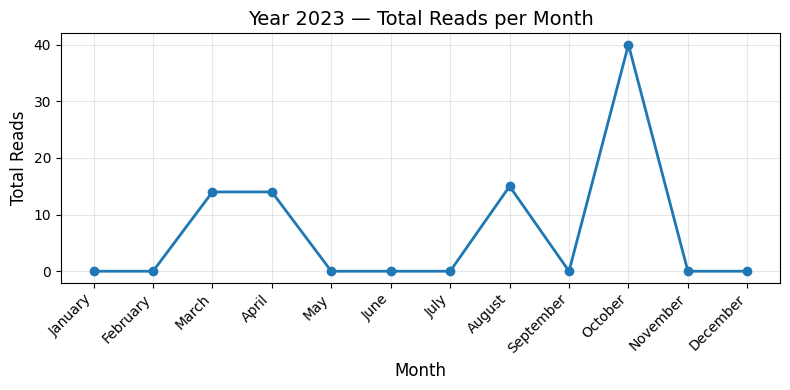

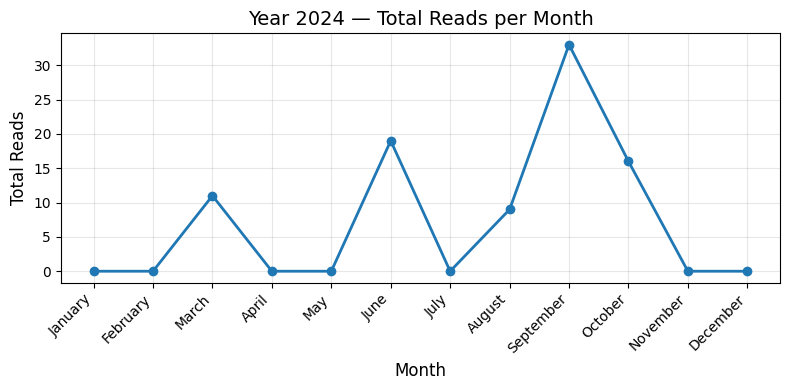

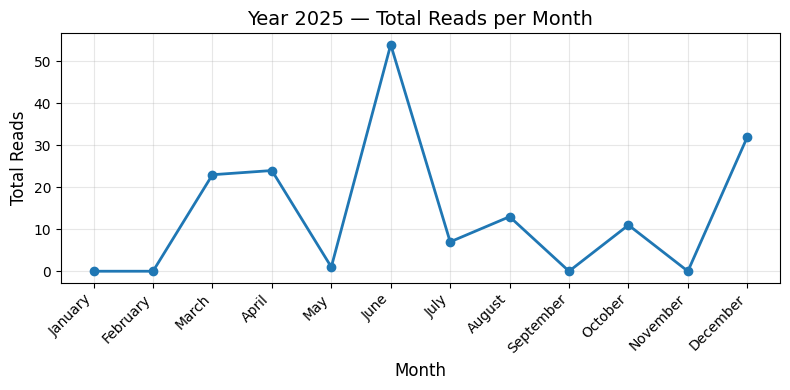

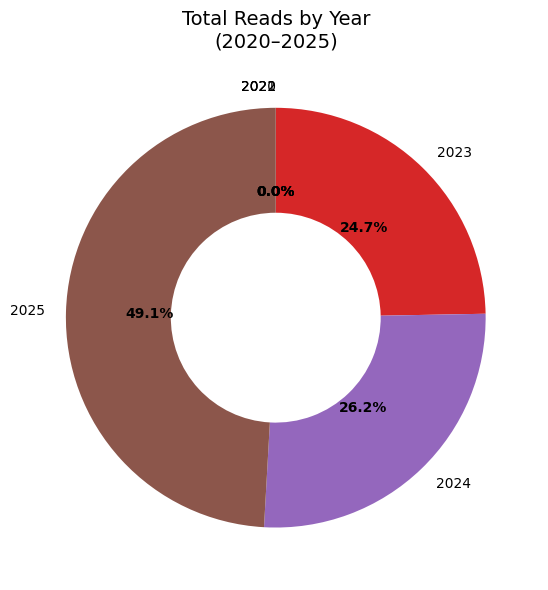

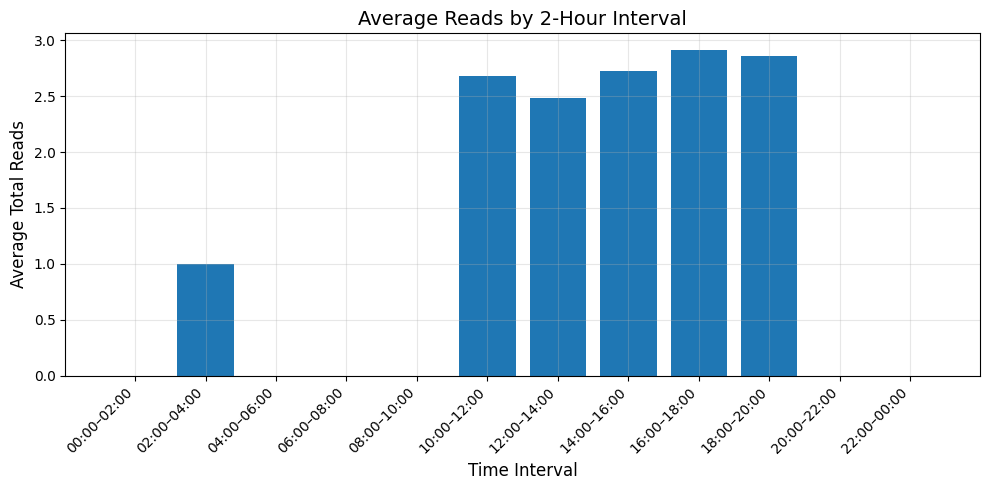

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import calendar


notebook_dir = os.getcwd()
attendance_folder = os.path.abspath(
    os.path.join(notebook_dir, "..", "Database", "attendance_lists")
)

if not os.path.isdir(attendance_folder):
    raise FileNotFoundError(
        f"Attendance folder not found: {attendance_folder}"
    )
    
dataframes = []

for filename in sorted(os.listdir(attendance_folder)):
    if not filename.lower().endswith(".csv"):
        continue
    file_path = os.path.join(attendance_folder, filename)
    df = pd.read_csv(file_path, engine="python")


    if df.empty or 'last_log_date' not in df.columns:
        continue

    df['last_log_date'] = pd.to_datetime(
        df['last_log_date'],
        dayfirst=True,
        errors='coerce'
    )
    df = df.dropna(subset=['last_log_date'])
    df['year'] = df['last_log_date'].dt.year
    df['month'] = df['last_log_date'].dt.month

    dataframes.append(df)

if not dataframes:
    raise RuntimeError("No valid attendance data found.")

all_data = pd.concat(dataframes, ignore_index=True)
monthly_totals = (
    all_data.groupby(['year', 'month'], 
    as_index=False)['total_reads'].sum()
)


month_labels = list(calendar.month_name)[1:]
for year in sorted(monthly_totals['year'].unique()):
    yearly_data = (
        monthly_totals[monthly_totals['year'] == year]
        .set_index('month')
        .reindex(range(1, 13), fill_value=0)
    )
    plt.figure(figsize=(8, 4))
    plt.plot(
        yearly_data.index,
        yearly_data['total_reads'],
        marker='o',
        linestyle='-',
        linewidth=2
    )
    plt.title(f"Year {year} — Total Reads per Month", fontsize=14)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Total Reads", fontsize=12)
    plt.xticks(
        ticks=range(1, 13),
        labels=month_labels,
        rotation=45,
        ha='right'
    )
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


yearly_totals = (
    all_data
    .groupby('year')['total_reads']
    .sum()
    .reindex(range(2020, 2026), fill_value=0)
)
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    yearly_totals,
    labels=yearly_totals.index.astype(str),
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops=dict(width=0.5)
)
plt.setp(autotexts, size=10, weight="bold")
plt.title("Total Reads by Year\n(2020–2025)", fontsize=14)
plt.tight_layout()
plt.show()


all_data['hour'] = all_data['last_log_date'].dt.hour
all_data['bin_start'] = (all_data['hour'] // 2) * 2

intervals = list(range(0, 24, 2))
avg_reads = (
    all_data
    .groupby('bin_start')['total_reads']
    .mean()
    .reindex(intervals, fill_value=0)
)

interval_labels = [
    f"{str(h).zfill(2)}:00–{str((h + 2) % 24).zfill(2)}:00"
    for h in intervals
]

plt.figure(figsize=(10, 5))
plt.bar(interval_labels, avg_reads.values)
plt.title("Average Reads by 2-Hour Interval", fontsize=14)
plt.xlabel("Time Interval", fontsize=12)
plt.ylabel("Average Total Reads", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
